In [49]:
import torch
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import os
from pathlib import Path
from PIL import Image
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

In [50]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)

def show_dataloader_images(dataloader, class_names):
    inputs, classes = next(iter(dataloader))
    out = torchvision.utils.make_grid(inputs)
    imshow(out, title=[class_names[x] for x in classes])

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomRotation(degrees=10),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.GaussianBlur(kernel_size=(5, 5), sigma=(0.01, .5)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

In [51]:
data_dir = './data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                  for x in ['train', 'val', 'test']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                              shuffle=True, num_workers=0)
               for x in ['train', 'val', 'test']}

class_names = image_datasets['train'].classes

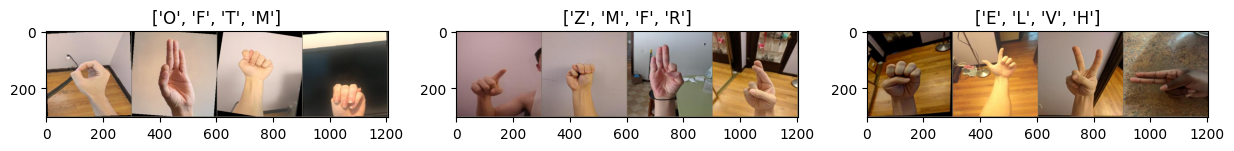

In [52]:
# sample images

plt.figure(figsize=(15, 7))
for i, (phase, dataloader) in enumerate(dataloaders.items()):
    plt.subplot(1, 3, i+1)
    plt.title(f'{phase} images')
    show_dataloader_images(dataloader, class_names)

plt.show()

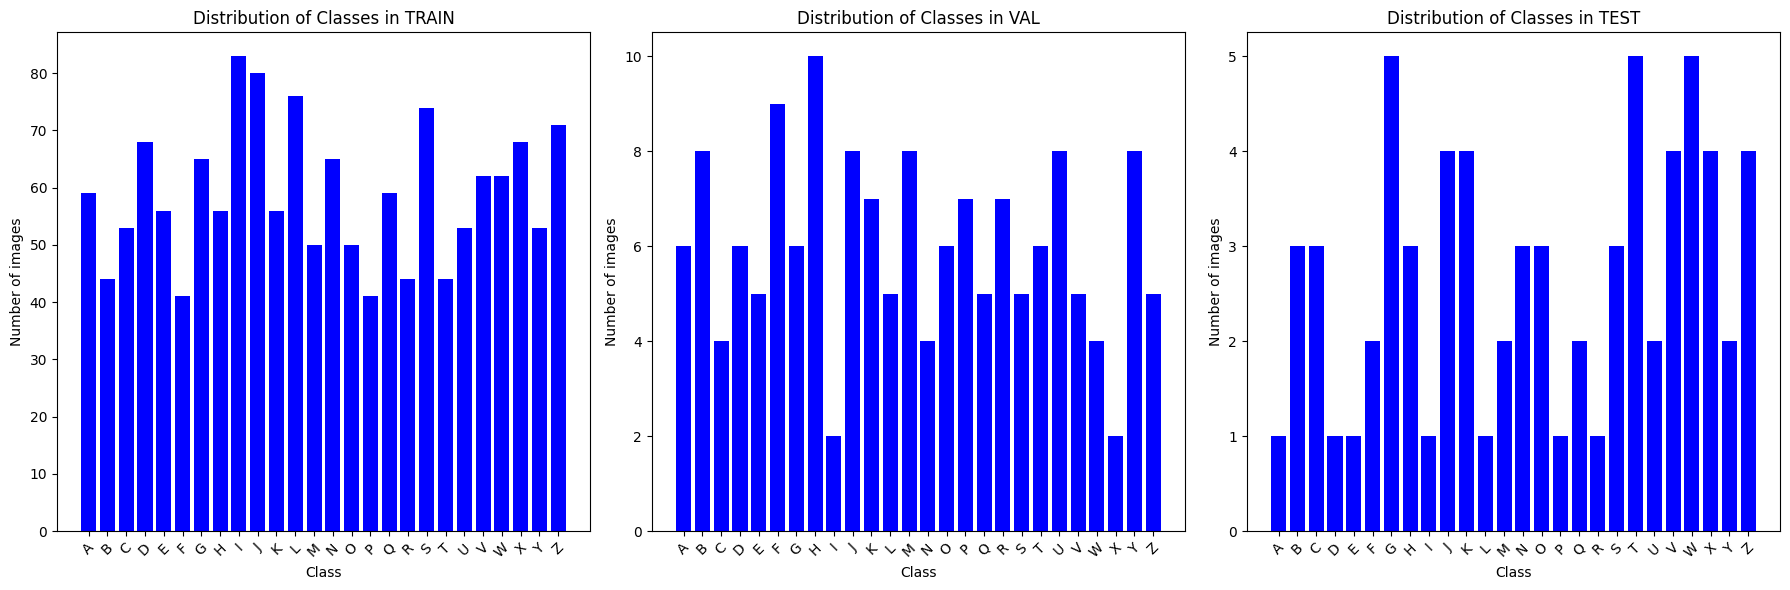

In [53]:
# distribution of samples in each letter across train, val, test

fig, axs = plt.subplots(1, 3, figsize=(18, 6))

for i, dir in enumerate(['./data/train', './data/val', './data/test']):
    class_counts = {}
    for class_name in sorted(os.listdir(dir)):
        class_path = os.path.join(dir, class_name)
        class_counts[class_name] = len(os.listdir(class_path))
    
    axs[i].bar(class_counts.keys(), class_counts.values(), color='blue')
    axs[i].set_xlabel('Class')
    axs[i].set_ylabel('Number of images')
    axs[i].set_title(f'Distribution of Classes in {dir.split("/")[-1].upper()}')
    axs[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

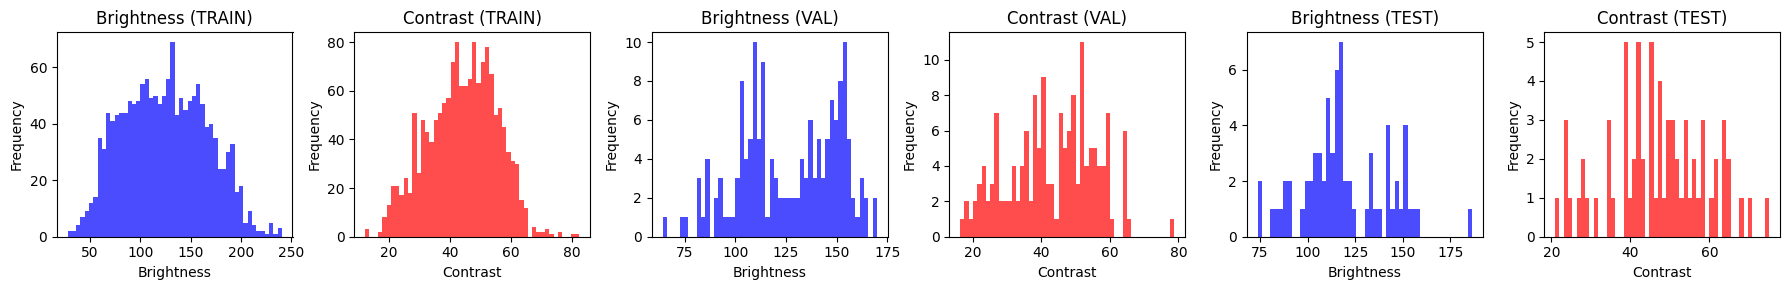

In [54]:
# brightness and contrast 
fig, axs = plt.subplots(1, 6, figsize=(18, 3))

for i, dir in enumerate(['./data/train', './data/val', './data/test']):
    brightness, contrast = [], []
    for class_name in os.listdir(dir):
        class_path = os.path.join(dir, class_name)
        for image_name in os.listdir(class_path):
            image_path = os.path.join(class_path, image_name)
            with Image.open(image_path).convert('L') as img:  
                pixels = np.array(img.getdata())
                brightness.append(np.mean(pixels))
                contrast.append(np.std(pixels))
    
    # Plotting
    axs[i*2].hist(brightness, bins=50, color='blue', alpha=0.7)
    axs[i*2].set_title(f'Brightness ({dir.split("/")[-1].upper()})')
    axs[i*2].set_xlabel('Brightness')
    axs[i*2].set_ylabel('Frequency')
    
    axs[i*2 + 1].hist(contrast, bins=50, color='red', alpha=0.7)
    axs[i*2 + 1].set_title(f'Contrast ({dir.split("/")[-1].upper()})')
    axs[i*2 + 1].set_xlabel('Contrast')
    axs[i*2 + 1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

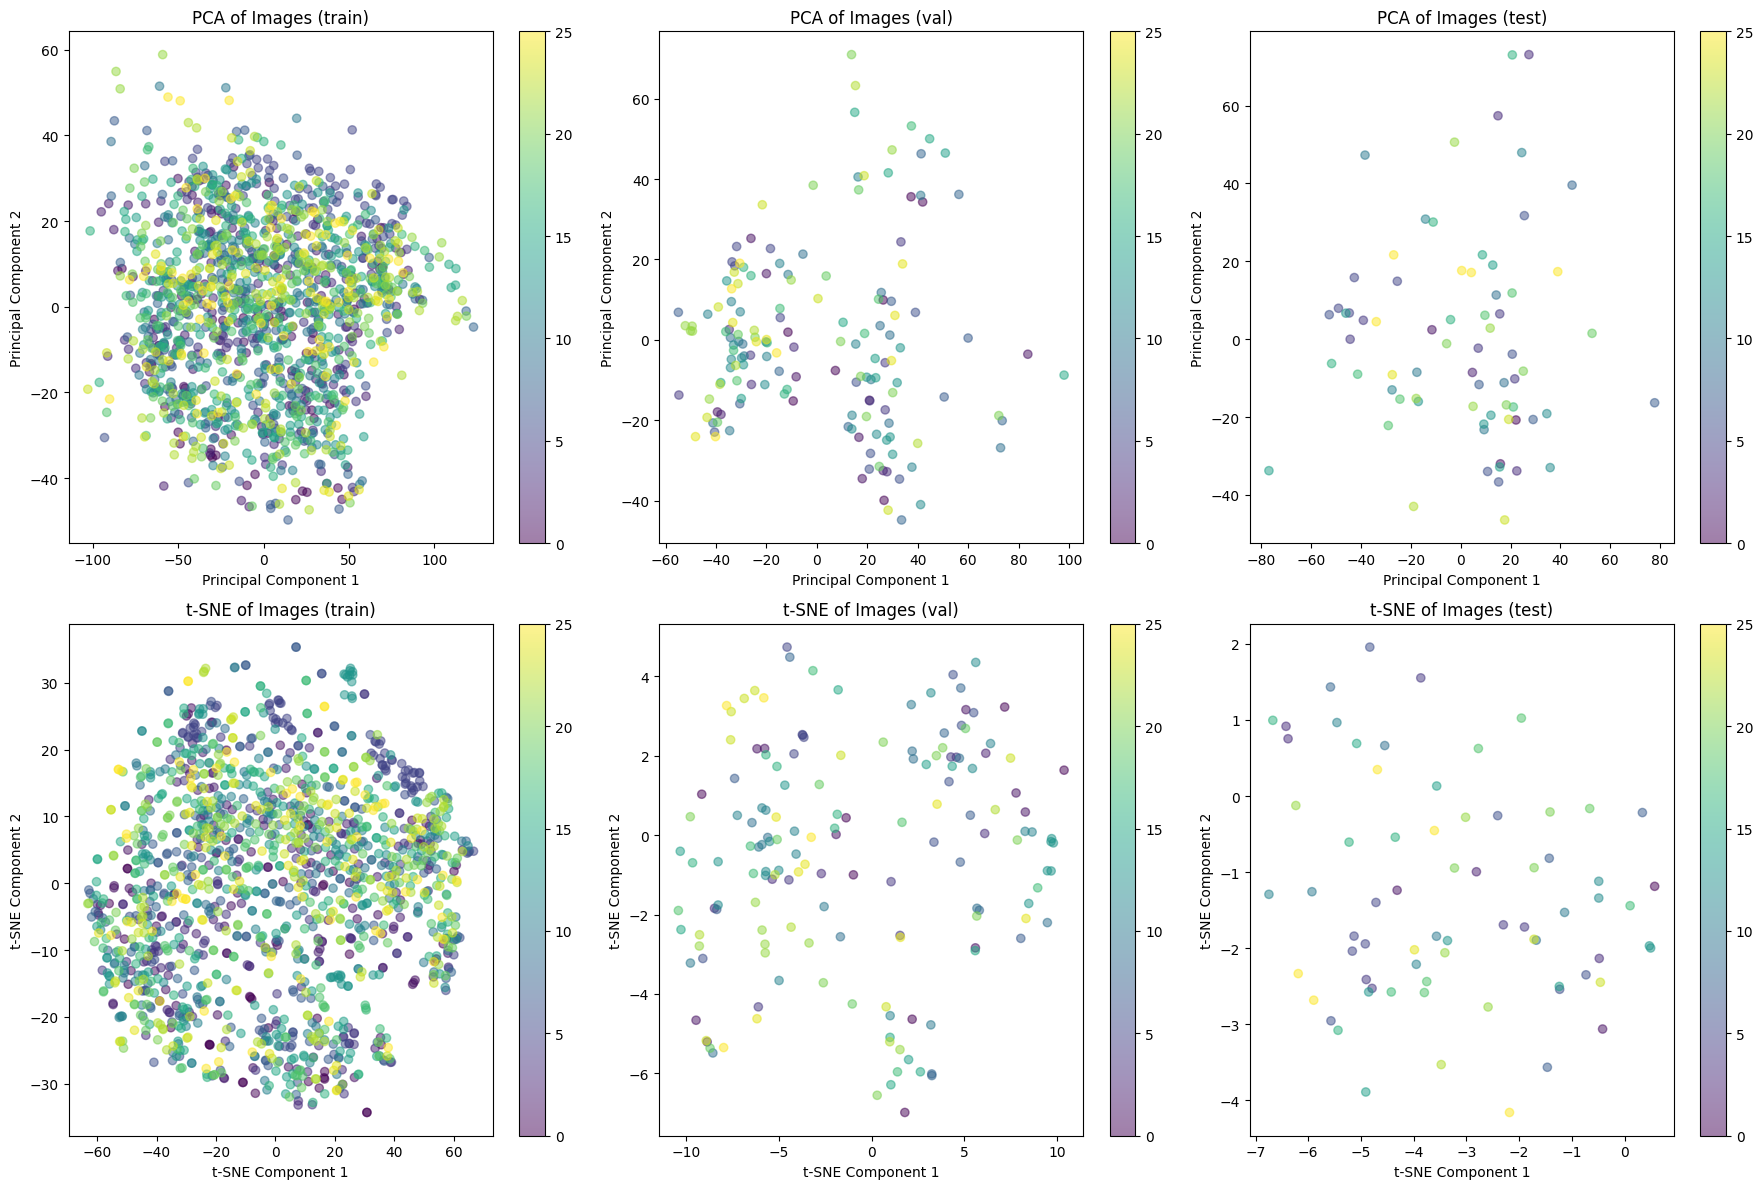

In [55]:
# Dimensionality Reduction of Image Features
fig, axs = plt.subplots(2, 3, figsize=(18, 12))

for i, dir in enumerate(['./data/train', './data/val', './data/test']):
    X = [] 
    labels = [] 
    for class_index, class_name in enumerate(os.listdir(dir)):
        class_path = os.path.join(dir, class_name)
        for image_name in os.listdir(class_path):
            image_path = os.path.join(class_path, image_name)
            with Image.open(image_path) as img:
                img = img.resize((64, 64)).convert('L')  
                X.append(np.array(img).flatten())
                labels.append(class_index)
    
    X = np.array(X)
    labels = np.array(labels)
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)
    
    tsne = TSNE(n_components=2, random_state=42)
    X_tsne = tsne.fit_transform(X_scaled)
    
    axs[0, i].scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', alpha=0.5)
    axs[0, i].set_title(f'PCA of Images ({dir.split("/")[-1]})')
    axs[0, i].set_xlabel('Principal Component 1')
    axs[0, i].set_ylabel('Principal Component 2')
    fig.colorbar(sc, ax=axs[0, i])
    
    # Plotting t-SNE
    axs[1, i].scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels, cmap='viridis', alpha=0.5)
    axs[1, i].set_title(f't-SNE of Images ({dir.split("/")[-1]})')
    axs[1, i].set_xlabel('t-SNE Component 1')
    axs[1, i].set_ylabel('t-SNE Component 2')
    fig.colorbar(sc, ax=axs[1, i])

plt.tight_layout()
plt.show()

In [46]:
###